Firt name: Kamiar (Kamy)\
Last name: Asgari (Gary)\
USC ID: 4590556658\
Github Username: kamiarasgari

In [ ]:
import numpy as np
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications import efficientnet, vgg16
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, GlobalMaxPooling2D
from tensorflow.keras.utils import to_categorical

import warnings
warnings.filterwarnings("ignore")

random_state = 42

### Load the data

In [2]:
# path to the dataset
data_path = '../Data/images'
num_classes = len(os.listdir(data_path))

# Set the image size for preprocessing
img_width, img_height = 224, 224

# List all class folders
class_folders = os.listdir(data_path)

# Create a list to store images and labels
images = []
labels = []

# Load images and labels
for class_idx, class_folder in enumerate(class_folders):
    class_path = os.path.join(data_path, class_folder)
    for img_name in os.listdir(class_path):
        img = load_img(os.path.join(class_path, img_name), target_size=(img_width, img_height))
        img_array = img_to_array(img)
        images.append(img_array)
        labels.append(class_idx)

# Convert the lists to numpy arrays
images = np.array(images, dtype='float32')
labels = np.array(labels)

# Convert y_train to one-hot encoded format
num_classes = len(np.unique(labels))
y_train_onehot = to_categorical(labels, num_classes=num_classes)

# Split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(images, y_train_onehot, test_size=0.15, random_state=random_state)

# EfficientNetB0

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=15/70   # 0.7 -> trainig, 0.15 -> val
    )

datagen.fit(x_train)

In [ ]:
# Load the pre-trained EfficientNetB0 model (include_top=False excludes the final classification layer)
base_model = efficientnet.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze the pre-trained layers
base_model.trainable = False

In [ ]:
model_Net0 = tf.keras.Sequential([
  base_model,
  Dropout(0.2),
  GlobalMaxPooling2D(),
  BatchNormalization(),
  Dense(64, activation='relu'),
  Dropout(0.2),
  Dense(num_classes, activation='softmax')  
])

model_Net0.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# trining for epochs ..
epochs = 100
train_ds = datagen.flow(x_train, y_train, batch_size=7, subset='training')
val_ds = datagen.flow(x_train, y_train, subset='validation')

history_Net0 = model_Net0.fit(train_ds,
            validation_data=val_ds,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=40, restore_best_weights=True)],
            epochs=epochs,
            use_multiprocessing=True)

In [ ]:
# saving the model
model_Net0.save("../EfficientNetB0.keras")

# save the history
hist_df = pd.DataFrame(history_Net0.history) 
with open('../history_Net0.json', mode='w') as f:
    hist_df.to_json(f)

# VGG16

In [8]:
x_train_vgg16 = vgg16.preprocess_input(x_train.copy())
x_test_vgg16 = vgg16.preprocess_input(x_test.copy())

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=15/70   # 0.7 -> trainig, 0.15 -> val
    )

datagen.fit(x_train_vgg16)

In [ ]:
# Load the pre-trained VGG16 model (include_top=False excludes the final classification layer)
base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze the pre-trained layers
base_model.trainable = False

In [ ]:
model_VGG16 = tf.keras.Sequential([
  base_model,
  Dropout(0.2),
  GlobalMaxPooling2D(),
  BatchNormalization(),
  Dense(64, activation='relu'),
  Dropout(0.2),
  Dense(num_classes, activation='softmax')  
])

model_VGG16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# trining for epochs ..
epochs = 100
train_ds = datagen.flow(x_train_vgg16, y_train, batch_size=7, subset='training')
val_ds = datagen.flow(x_train_vgg16, y_train, subset='validation')

history_VGG16 = model_VGG16.fit(train_ds,
            validation_data=val_ds,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)],
            epochs=epochs,
            use_multiprocessing=True)

In [ ]:
# saving the model
model_VGG16.save("../VGG16.keras")

# save the history
hist_df = pd.DataFrame(history_VGG16.history) 
with open('../history_VGG16.json', mode='w') as f:
    hist_df.to_json(f)

# Comparison

In [ ]:
model_Net0 = tf.keras.models.load_model('../saved/EfficientNetB0.keras')
model_VGG16 = tf.keras.models.load_model('../saved/VGG16.keras')

history_Net0_df = pd.read_json('../saved/history_Net0.json')
history_VGG16_df = pd.read_json('../saved/history_VGG16.json')

### Training and Validation Loss

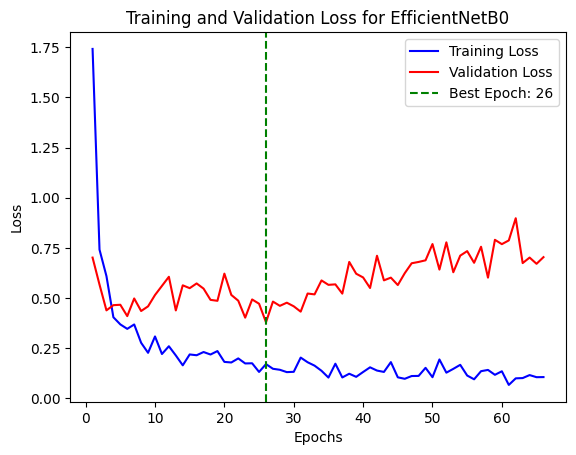

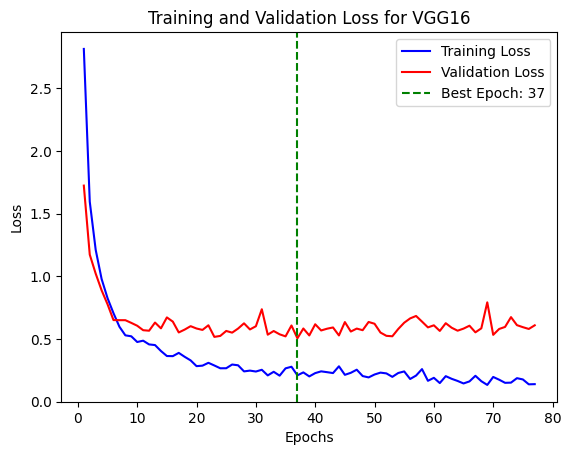

In [4]:
# EfficientNetB0
training_loss = history_Net0_df['loss'].values
validation_loss = history_Net0_df['val_loss'].values
epochs = range(1, len(training_loss) + 1)
plt.plot(epochs, training_loss, 'b', label='Training Loss')
plt.plot(epochs, validation_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss for EfficientNetB0')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

best_model = model_Net0
best_epoch_Net0 = np.argmin(validation_loss) + 1
plt.axvline(x=best_epoch_Net0, color='g', linestyle='--', label=f'Best Epoch: {best_epoch_Net0}')
plt.legend()
plt.show()

# VGG16
training_loss = history_VGG16_df['loss'].values
validation_loss = history_VGG16_df['val_loss'].values
epochs = range(1, len(training_loss) + 1)
plt.plot(epochs, training_loss, 'b', label='Training Loss')
plt.plot(epochs, validation_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss for VGG16')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

best_model = model_VGG16
best_epoch_VGG16 = np.argmin(validation_loss) + 1
plt.axvline(x=best_epoch_VGG16, color='g', linestyle='--', label=f'Best Epoch: {best_epoch_VGG16}')
plt.legend()
plt.show()

### Training and Validation accuracy

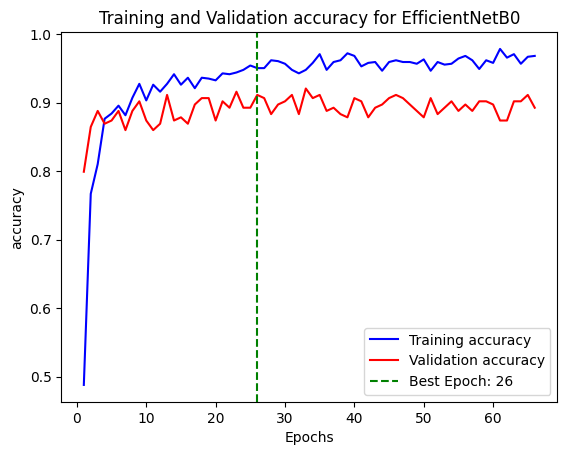

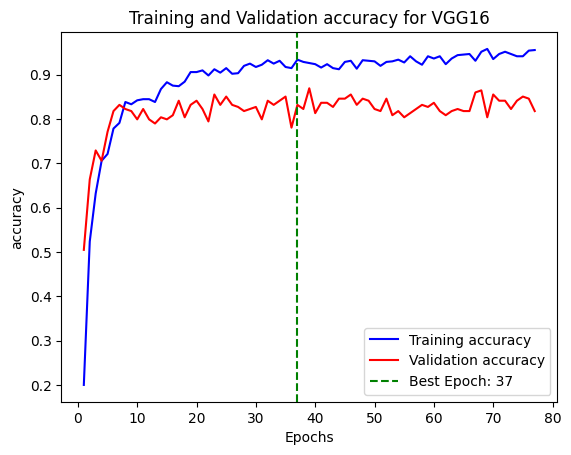

In [5]:
# EfficientNetB0
training_accuracy = history_Net0_df['accuracy'].values
validation_accuracy = history_Net0_df['val_accuracy'].values
epochs = range(1, len(training_accuracy) + 1)
plt.plot(epochs, training_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, validation_accuracy, 'r', label='Validation accuracy')
plt.title('Training and Validation accuracy for EfficientNetB0')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()

plt.axvline(x=best_epoch_Net0, color='g', linestyle='--', label=f'Best Epoch: {best_epoch_Net0}')
plt.legend()
plt.show()

# VGG16
training_accuracy = history_VGG16_df['accuracy'].values
validation_accuracy = history_VGG16_df['val_accuracy'].values
epochs = range(1, len(training_accuracy) + 1)
plt.plot(epochs, training_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, validation_accuracy, 'r', label='Validation accuracy')
plt.title('Training and Validation accuracy for VGG16')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()

plt.axvline(x=best_epoch_VGG16, color='g', linestyle='--', label=f'Best Epoch: {best_epoch_VGG16}')
plt.legend()
plt.show()

### Precision, Recall, and F1 for training+val data

In [6]:
# EfficientNetB0
y_pred = model_Net0.predict(x_train,verbose=0)
y_pred_labels = [np.argmax(pred) for pred in y_pred]
y_true_labels = [np.argmax(true_label) for true_label in y_train]
report = classification_report(y_true_labels, y_pred_labels)

print("Classification Report for EfficientNetB0 on training+val data:")
print(report)

Classification Report for EfficientNetB0 on training+val data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.98      1.00      0.99        49
           2       1.00      0.98      0.99        51
           3       1.00      1.00      1.00        49
           4       0.98      0.98      0.98        51
           5       0.96      1.00      0.98        49
           6       0.96      0.98      0.97        50
           7       1.00      0.97      0.99        39
           8       1.00      0.98      0.99        53
           9       0.94      0.96      0.95        49
          10       0.98      0.98      0.98        51
          11       1.00      1.00      1.00        51
          12       0.94      0.94      0.94        50
          13       1.00      0.93      0.96        58
          14       0.96      0.98      0.97        48
          15       1.00      1.00      1.00        49
          16      

In [11]:
# VGG16
y_pred = model_VGG16.predict(x_train_vgg16,verbose=0)
y_pred_labels = [np.argmax(pred) for pred in y_pred]
y_true_labels = [np.argmax(true_label) for true_label in y_train]
report = classification_report(y_true_labels, y_pred_labels)

print("Classification Report for VGG16 on training+val data:")
print(report)

Classification Report for VGG16 on training+val data:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        50
           1       1.00      1.00      1.00        49
           2       1.00      1.00      1.00        51
           3       0.98      1.00      0.99        49
           4       1.00      0.92      0.96        51
           5       0.98      1.00      0.99        49
           6       1.00      0.98      0.99        50
           7       1.00      0.97      0.99        39
           8       0.96      0.98      0.97        53
           9       0.98      0.92      0.95        49
          10       0.96      0.98      0.97        51
          11       0.89      1.00      0.94        51
          12       0.94      0.90      0.92        50
          13       0.93      0.95      0.94        58
          14       0.88      0.96      0.92        48
          15       1.00      0.98      0.99        49
          16       0.96    

### Precision, Recall, and F1 for test data

In [10]:
# EfficientNetB0
y_pred = model_Net0.predict(x_test,verbose=0)
y_pred_labels = [np.argmax(pred) for pred in y_pred]
y_true_labels = [np.argmax(true_label) for true_label in y_test]
report = classification_report(y_true_labels, y_pred_labels)

print("Classification Report for EfficientNetB0 on training+val data:")
print(report)

Classification Report for EfficientNetB0 on training+val data:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         9
           3       1.00      1.00      1.00         9
           4       1.00      0.89      0.94         9
           5       1.00      1.00      1.00        11
           6       0.90      1.00      0.95         9
           7       1.00      0.80      0.89         5
           8       0.75      1.00      0.86         6
           9       0.83      0.91      0.87        11
          10       1.00      1.00      1.00         8
          11       0.90      1.00      0.95         9
          12       1.00      0.90      0.95        10
          13       1.00      0.50      0.67         2
          14       0.85      0.92      0.88        12
          15       0.92      1.00      0.96        11
          16      

In [9]:
# VGG16
y_pred = model_VGG16.predict(x_test_vgg16,verbose=0)
y_pred_labels = [np.argmax(pred) for pred in y_pred]
y_true_labels = [np.argmax(true_label) for true_label in y_test]
report = classification_report(y_true_labels, y_pred_labels)

print("Classification Report for VGG16 on training+val data:")
print(report)

Classification Report for VGG16 on training+val data:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      0.89      0.94         9
           2       0.82      1.00      0.90         9
           3       0.90      1.00      0.95         9
           4       0.83      0.56      0.67         9
           5       1.00      0.91      0.95        11
           6       0.89      0.89      0.89         9
           7       1.00      0.80      0.89         5
           8       0.80      0.67      0.73         6
           9       1.00      0.73      0.84        11
          10       0.78      0.88      0.82         8
          11       0.69      1.00      0.82         9
          12       0.90      0.90      0.90        10
          13       0.50      0.50      0.50         2
          14       0.85      0.92      0.88        12
          15       1.00      1.00      1.00        11
          16       1.00    